# Metrics of selection (Fay and Wu's H, non-monotonicity D) and comparison against detection limit

In [26]:
from __future__ import division
import sys
import os
import time
import copy
import pickle

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

sys.path.append("../v7/")
import bct

output_dir = "../v8/outs"
output_suffix = ""
output_formats = [".pdf", ".png"]

def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.2}
mpl.rc('savefig', dpi=300)

mpl.rcParams['figure.dpi']= 300

sns.set_style("ticks")
sns.set_context("talk")

myColors = ["#E69F00", "#56B4E9", "#D55E00", "#009E73", "#7570b3", "#e31a1c", "#fb9a99", "#cab2d6"]

# Load data

In [4]:
# Lineage dynamics data
df_expanded = pd.read_csv("../v7/data/df_expanded.filtered.csv", index_col=0)
df_persistent = pd.read_csv("../v7/data/df_persistent.filtered.csv", index_col=0)
df_rest = pd.read_csv("../v7/data/df_rest.csv", index_col=0)

print "Lineages"
print "Expanded", df_expanded.shape[0]
print "Persistent", df_persistent.shape[0]
print "Rest", df_rest.shape[0]

Lineages
Expanded 87
Persistent 192
Rest 322


In [5]:
# Filter for lineages having enough sequences in 2x300 data set to make reasonable SFS
num_seq_V6_Full_cutoff = 100
df_rest = df_rest[df_rest["sequences_V6_Full"] >= num_seq_V6_Full_cutoff]

print "Expanded"
print df_expanded.shape
print
print "Persistent"
print df_persistent.shape
print
print "Rest", df_rest.shape

Expanded
(87, 30)

Persistent
(192, 30)

Rest (171, 30)


# Load and filter sequence data

In [6]:
def load_data_seqs(infile):
    usecols = [0, 10, 17, 22, 25, 27, 31, 65, 66, 67]
    names = ["uid", "lineage_uid", "patient_uid", "year_visit_str",
             "V_germline", "J_germline", "isotype",
             "mut_germline_positions", "mut_germline_before", "mut_germline_after"]
    dtype = dict([(col, np.object) for col in names])
    dtype["uid"] = np.int64
    dtype["lineage_uid"] = np.int64
    dtype["patient_uid"] = np.int64
    df = pd.read_csv(infile, usecols=usecols, names=names, dtype=dtype, sep="\t", header=None, index_col=None, na_values=["\N"])
    df = df.loc[df["year_visit_str"] == "V6_Full"] # Use only 2x300 sequences
    return df

In [7]:
# Load sequence data (without lineage annotations)
infile = "../v5/data/Bcell_flu_high_res.sequences.csv"
df_seqs_all = load_data_seqs(infile)
print df_seqs_all.shape
print "Unique patients:", df_seqs_all.patient_uid.unique()
print "Number of sequences:", df_seqs_all.shape[0]
df_seqs_all.head()

(1041595, 10)
Unique patients: [2 3 6 7 8]
Number of sequences: 1041595


,uid,lineage_uid,patient_uid,year_visit_str,V_germline,J_germline,isotype,mut_germline_positions,mut_germline_before,mut_germline_after
461754,29902010100000002,20201010000037405,2,V6_Full,IGHV4-59*01,IGHJ3*02,IgM,NaN,NaN,NaN
461755,29902010100000004,20201010000000500,2,V6_Full,IGHV3-9*01,IGHJ5*02,IgA,"V14,V21,V31,V32,V82,V83,V90,V97,V163,V169,V170...","T,T,T,T,A,C,T,G,A,A,G,T,C,A,C,C,C,G,G,C","C,C,C,G,G,A,A,C,G,G,C,C,G,G,G,G,T,A,A,T"
461756,29902010100000010,20201010000064503,2,V6_Full,IGHV4-38-2*01,IGHJ4*02,IgA,"V30,V90,V107,V121,V150,V163,V170,V203,V214,V22...","A,C,G,C,G,A,G,T,G,A,A,G,C,T","G,G,A,T,C,G,A,C,T,G,C,C,T,C"
461757,29902010100000014,20201010000000267,2,V6_Full,IGHV4-59*08,IGHJ4*02,IgG,"V69,V76,V77,V92,V93,V95,V96,V99,V123,V155,V156...","T,G,G,G,T,A,C,C,A,A,T,T,A,G,G,T,G,G,A,A,G,A,C,T","C,C,T,T,G,C,T,T,C,T,C,G,G,C,A,G,C,A,C,G,A,G,T,C"
461758,29902010100000019,20201010000000001,2,V6_Full,IGHV3-15*01,IGHJ5*02,IgG,"V21,V39,V40,V82,V88,V89,V104,V105,V147,V149,V1...","T,G,C,A,A,G,G,C,C,G,G,A,C,T,A,A,C,C,C,T,C,C,G,...","A,A,G,G,G,A,A,T,T,A,C,G,T,G,G,T,A,T,G,C,T,G,A,..."


In [8]:
# Only keep lineages that are in our focal set
df_seqs = df_seqs_all[df_seqs_all["lineage_uid"].isin(list(df_expanded.index) + list(df_persistent.index) + list(df_rest.index))]
print df_seqs.shape

(481150, 10)


In [20]:
# Write filtered data to file
df_rest.to_csv("data/df_rest.filtered.csv")
df_seqs.to_csv("data/df_seqs.filtered_V6_Full.rest.csv")

# Calculate Fay and Wu's H

# Tally mutation counts (not frequencies) for each mutation

In [9]:
derived_mut_counts, derived_mut_counts_lineageSizes = bct.get_muts_counts_all(df_seqs) # takes ~160 sec

Wall clock time 8.85683608055



In [10]:
germline_muts = bct.load_germline_muts("../v7/data/")
lineage_to_alleles = bct.make_lineage_to_alleles(df_seqs)
derived_mut_counts = bct.drop_germline_muts(derived_mut_counts, germline_muts, lineage_to_alleles)

Dropped germline mutations 266


# Calculate Fay and Wu's H based on counts

In [11]:
def calc_H(mut_counts, n):
    counts = pd.Series(mut_counts).value_counts()
    theta_H = sum(2 * np.array(counts.index)**2 * counts) / (n * (n-1))
    theta_pi = sum(2 * counts * np.array(counts.index) * (n - counts.index)) / (n * (n-1))
    H = theta_pi - theta_H
    return H

In [12]:
# test on a couple lineages
print calc_H(derived_mut_counts[df_expanded.index[0]].values(), derived_mut_counts_lineageSizes[df_expanded.index[0]])
print calc_H(derived_mut_counts[df_persistent.index[0]].values(), derived_mut_counts_lineageSizes[df_persistent.index[0]])
print calc_H(derived_mut_counts[df_rest.index[0]].values(), derived_mut_counts_lineageSizes[df_rest.index[0]])

-14.4997474597
35.1719545745
-17.7848166261


In [13]:
H_expanded = [calc_H(derived_mut_counts[x], derived_mut_counts_lineageSizes[x]) for x in df_expanded.index]
H_persistent = [calc_H(derived_mut_counts[x], derived_mut_counts_lineageSizes[x]) for x in df_persistent.index]
H_rest = [calc_H(derived_mut_counts[x], derived_mut_counts_lineageSizes[x]) for x in df_rest.index]

# Plot distributions of Fay and Wu's H

MannwhitneyuResult(statistic=4491.0, pvalue=3.1318013788319136e-10)

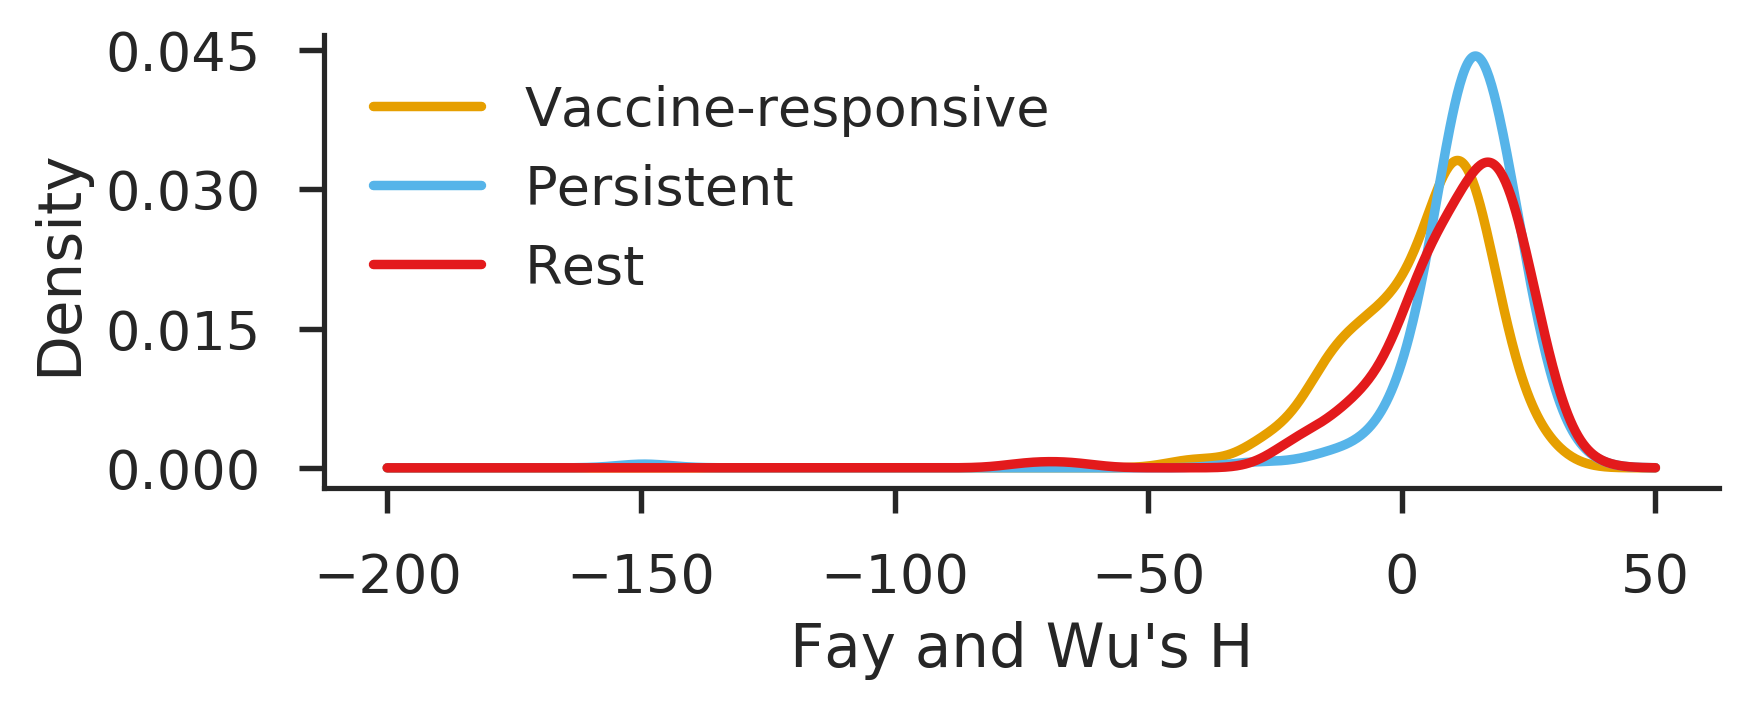

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6,2))
xs = np.linspace(-200,50,1000)
density = scipy.stats.gaussian_kde(H_expanded)
ax.plot(xs, density(xs), c=myColors[0], label="Vaccine-responsive")
density = scipy.stats.gaussian_kde(H_persistent)
ax.plot(xs, density(xs), c=myColors[1], label="Persistent")
density = scipy.stats.gaussian_kde(H_rest)
ax.plot(xs, density(xs), c=myColors[5], label="Rest")
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4))
ax.set_xlabel("Fay and Wu's H")
ax.set_ylabel("Density")
ax.legend(loc="upper left")
sns.despine()
# save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_Distributions", output_dir, output_suffix, output_formats, savefig_args)
print

scipy.stats.mannwhitneyu(H_expanded, H_persistent)

# Calculate significance by comparison with size-matched simulations

In [16]:
# Load fit parameters for size-matched ensembles
fit_params_H_kingman = pickle.load(open("../v7/data/SFS_CalculateMetrics_FayAndWusH_FitParams_kingman.pickle", 'r'))
fit_params_H_BSC = pickle.load(open("../v7/data/SFS_CalculateMetrics_FayAndWusH_FitParams_BSC.pickle", 'r'))
fit_params_H_neutralExpanding = pickle.load(open("../v7/data/SFS_CalculateMetrics_FayAndWusH_FitParams_NeutralExpanding.extrapolated.pickle", 'r'))

In [17]:
# Define functions to compare with size-matched simulations

def find_nearest(L,value):
    array = np.array(L)
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def calc_pvalue_matchedSimulations(H_focal, N_focal, params, model=scipy.stats.johnsonsu):
    
    # Find nearest N in ensemble
    N = find_nearest(params.keys(), N_focal)
    
    # Calculate p of H under nearest N
    myParams = params[N]
    p_low = model.cdf(H_focal, myParams[0], myParams[1], myParams[2], myParams[3]) # unpacking of params may need to be adjusted for different models
    p = p_low
    
    return p

In [18]:
# Example as test case

i = 0
lineage_uid = df_expanded.index[i]
H_focal = H_expanded[i]
N_focal = derived_mut_counts_lineageSizes[lineage_uid]

# pvalue = calc_pvalue_matchedSimulations(H_focal, N_focal, fit_params_H_kingman)
pvalue = calc_pvalue_matchedSimulations(H_focal, N_focal, fit_params_H_neutralExpanding)

print lineage_uid, N_focal, H_focal, pvalue

70201010000000001 9166 -14.4997474597 2.096065726970906e-10


In [19]:
# Reformat data as df
lineage_uids = list(df_expanded.index) + list(df_persistent.index) + list(df_rest.index)
df_metrics = pd.DataFrame({"lineage_uid": lineage_uids})
df_metrics.set_index("lineage_uid", inplace=True)
df_metrics["label_dynamics"] = ["Vaccine-responsive"]*len(df_expanded) + ["Persistent"]*len(df_persistent) + ["Rest"]*len(df_rest)
df_metrics["num_seq"] = [derived_mut_counts_lineageSizes[x] for x in df_metrics.index]
df_metrics["H"] = [calc_H(derived_mut_counts[x], df_metrics["num_seq"].loc[x]) for x in df_metrics.index]

In [20]:
# Calculate pvalues for all lineages
df_metrics["H_pvalue_kingman"] = [calc_pvalue_matchedSimulations(row["H"], row["num_seq"], fit_params_H_kingman)
                                  for uid, row in df_metrics.iterrows()]

In [21]:
df_metrics["H_pvalue_neutralExpanding"] = [calc_pvalue_matchedSimulations(row["H"], row["num_seq"],
                                                                          fit_params_H_neutralExpanding) for uid, row in df_metrics.iterrows()]

In [22]:
# Subset for convenience
df_metrics_expanded = df_metrics.loc[df_metrics["label_dynamics"] == "Vaccine-responsive"]
df_metrics_persistent = df_metrics.loc[df_metrics["label_dynamics"] == "Persistent"]
df_metrics_rest = df_metrics.loc[df_metrics["label_dynamics"] == "Rest"]

In [201]:
# Write to file
df_metrics.to_csv("data/df_metrics_epr.csv")

# Plot Fay and Wu's H

In [23]:
# Report statistics of selection

# Kingman model
print "How many lineages are selected?"
print df_metrics.loc[df_metrics["H_pvalue_kingman"] < 0.05].shape[0]
print
print "Fraction of vaccine-responsive lineages selected"
print np.mean(df_metrics_expanded["H_pvalue_kingman"] < 0.05)
print
print "Fraction of persistent lineages selected"
print np.mean(df_metrics_persistent["H_pvalue_kingman"] < 0.05)
print
print "Fraction of rest lineages selected"
print np.mean(df_metrics_rest["H_pvalue_kingman"] < 0.05)

How many lineages are selected?
63

Fraction of vaccine-responsive lineages selected
0.3103448275862069

Fraction of persistent lineages selected
0.057291666666666664

Fraction of rest lineages selected
0.14619883040935672


In [24]:
# expanding neutral model
print "How many lineages are selected?"
print df_metrics.loc[df_metrics["H_pvalue_neutralExpanding"] < 0.05].shape[0]
print
print "Fraction of vaccine-responsive lineages selected"
print np.mean(df_metrics_expanded["H_pvalue_neutralExpanding"] < 0.05)
print
print "Fraction of persistent lineages selected"
print np.mean(df_metrics_persistent["H_pvalue_neutralExpanding"] < 0.05)
print
print "Fraction of rest lineages selected"
print np.mean(df_metrics_rest["H_pvalue_neutralExpanding"] < 0.05)

How many lineages are selected?
104

Fraction of vaccine-responsive lineages selected
0.42528735632183906

Fraction of persistent lineages selected
0.11979166666666667

Fraction of rest lineages selected
0.2573099415204678


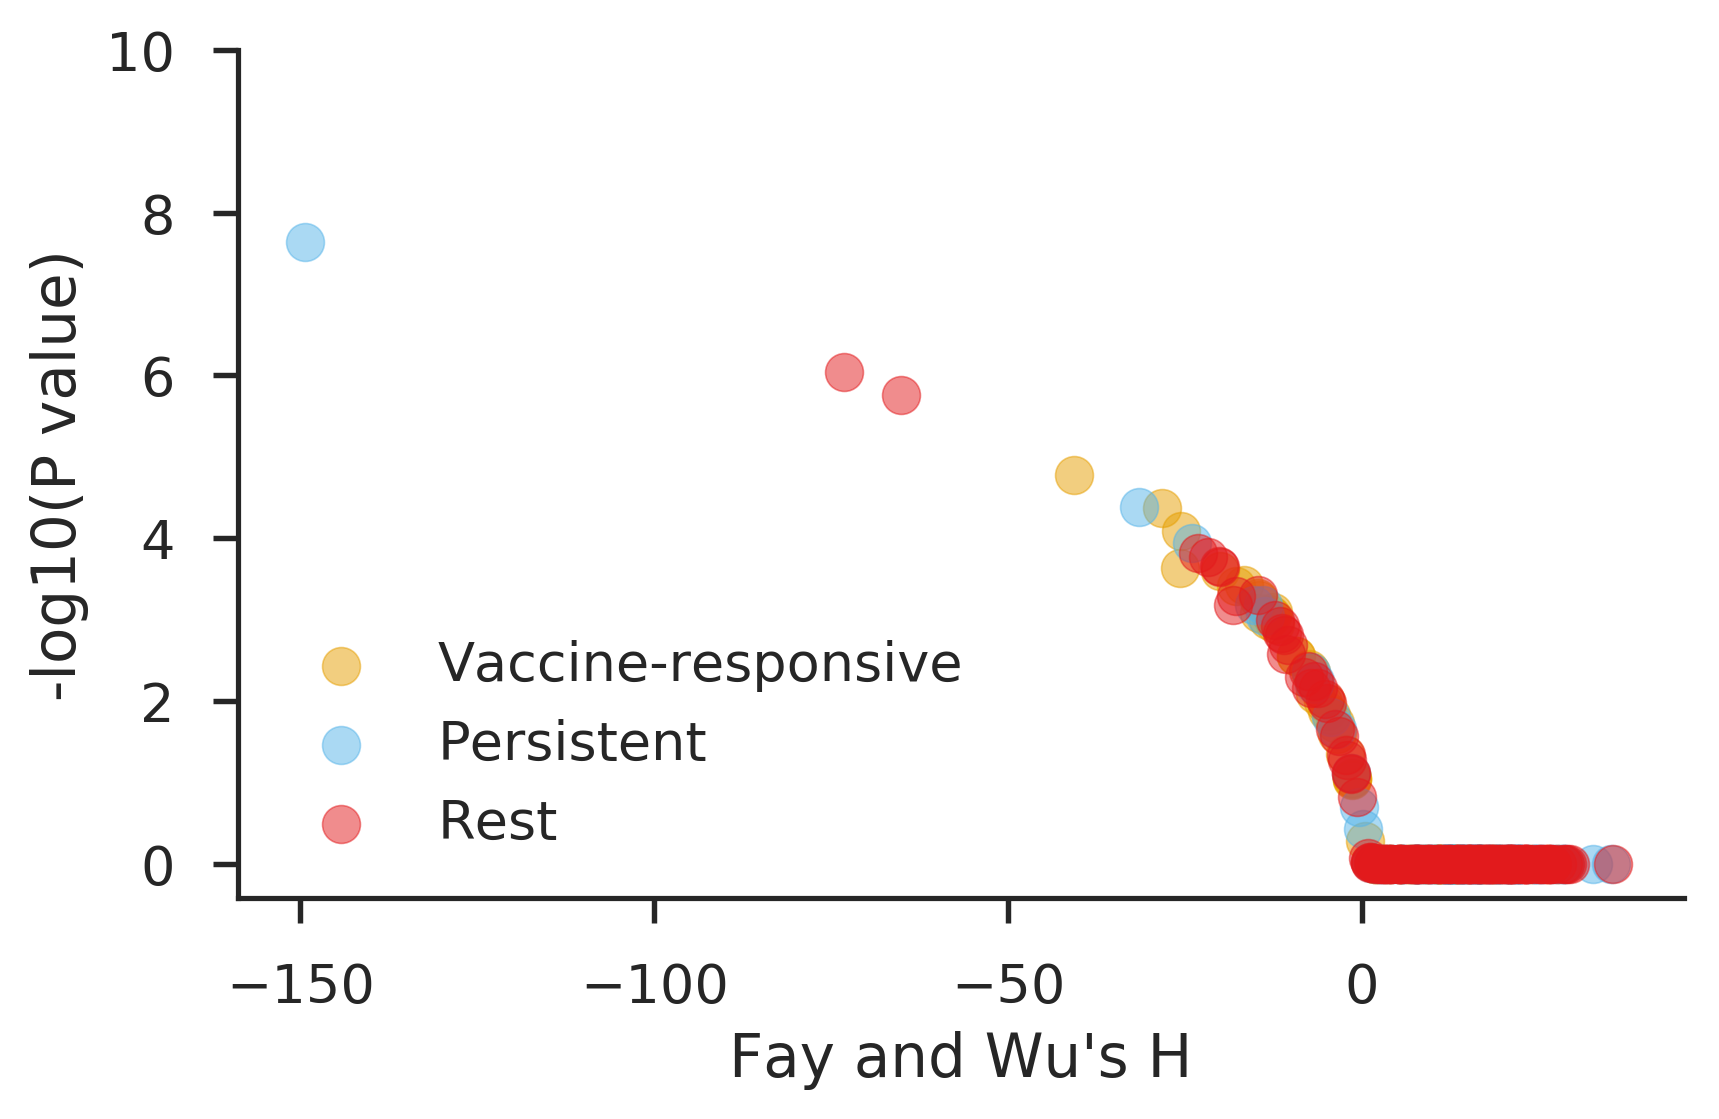

In [25]:
# Plot P value versus H as a sanity check for neutral model
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(df_metrics_expanded["H"], -np.log10(df_metrics_expanded["H_pvalue_kingman"]),
           c=myColors[0], alpha=0.5, label="Vaccine-responsive")
ax.scatter(df_metrics_persistent["H"], -np.log10(df_metrics_persistent["H_pvalue_kingman"]),
           c=myColors[1], alpha=0.5, label="Persistent")
ax.scatter(df_metrics_rest["H"], -np.log10(df_metrics_rest["H_pvalue_kingman"]),
           c=myColors[5], alpha=0.5, label="Rest")
ax.set_ylim(top=10)
ax.set_xlabel("Fay and Wu's H")
ax.set_ylabel("-log10(P value)")
ax.legend(loc="lower left")
sns.despine()
plt.tight_layout()

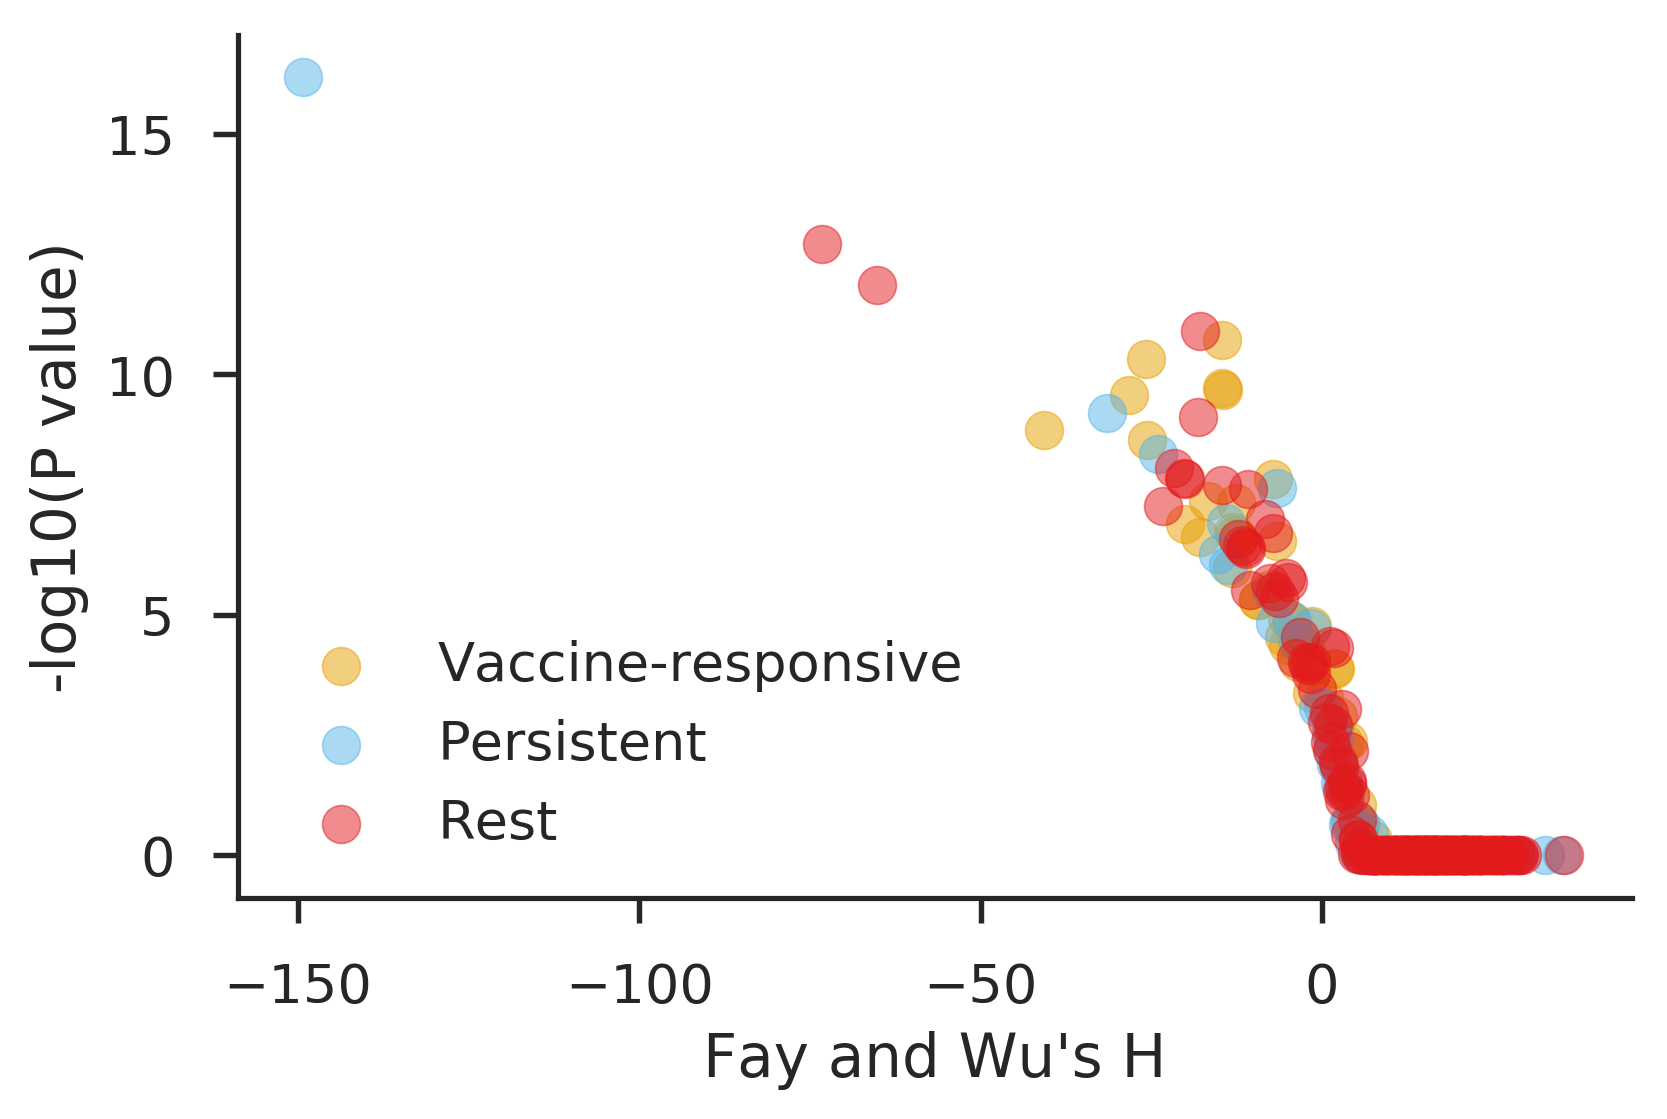

In [27]:
# Plot P value versus H as a sanity check for neutral expanding model
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(df_metrics_expanded["H"], -np.log10(df_metrics_expanded["H_pvalue_neutralExpanding"]),
           c=myColors[0], alpha=0.5, label="Vaccine-responsive")
ax.scatter(df_metrics_persistent["H"], -np.log10(df_metrics_persistent["H_pvalue_neutralExpanding"]),
           c=myColors[1], alpha=0.5, label="Persistent")
ax.scatter(df_metrics_rest["H"], -np.log10(df_metrics_rest["H_pvalue_neutralExpanding"]),
           c=myColors[5], alpha=0.5, label="Rest")
# ax.set_ylim(top=10)
ax.set_xlabel("Fay and Wu's H")
ax.set_ylabel("-log10(P value)")
ax.legend(loc="lower left")
sns.despine()
plt.tight_layout()

# Plot distribution of P values by comparison with simulations (null model is Kingman)

In [28]:
# Functions for generating P value distributions by sampling

def sample_from_size_matched_distributions(sizes, fit_params_generator, fit_params_null, num_reps):
    X = []
    model = scipy.stats.johnsonsu
    np.random.seed(seed=0) # fix random seed
    for i in xrange(num_reps):
        N = np.random.choice(sizes)
        nearest_N = find_nearest(fit_params_generator.keys(), N)
        my_fit_params = fit_params_generator[nearest_N]
        x = model.rvs(a=my_fit_params[0],
                      b=my_fit_params[1], 
                      loc=my_fit_params[2],
                      scale=my_fit_params[3],
                      size=1)[0]
        my_fit_params_null = fit_params_null[nearest_N]
        p = model.cdf(x,
                      my_fit_params_null[0],
                      my_fit_params_null[1],
                      my_fit_params_null[2],
                      my_fit_params_null[3])
        X.append(p)
    return np.array(X)

In [29]:
# Sample for VR
label = "Vaccine-responsive"
lineage_sizes = df_metrics_expanded["num_seq"]
print lineage_sizes.shape[0], "lineages"

pvalue_H_neutral_expanded_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                               fit_params_H_kingman,
                                                                               fit_params_H_kingman,
                                                                               10000)

pvalue_H_neutralExpanding_expanded_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                               fit_params_H_neutralExpanding,
                                                                               fit_params_H_kingman,
                                                                               10000)

pvalue_H_BSC_expanded_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                           fit_params_H_BSC,
                                                                           fit_params_H_kingman,
                                                                           10000)

87 lineages


MannwhitneyuResult(statistic=286426.0, pvalue=1.9673071052453415e-08)
MannwhitneyuResult(statistic=300268.0, pvalue=3.147663499667479e-07)
MannwhitneyuResult(statistic=36483786.0, pvalue=1.1783893053111682e-240)


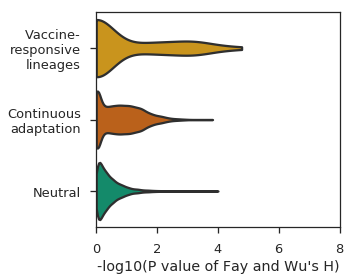

In [45]:
# Plot
data_obs = df_metrics_expanded["H_pvalue_kingman"]
data = [data_obs, pvalue_H_BSC_expanded_sizeMatched, pvalue_H_neutral_expanded_sizeMatched]

data = [-np.log10(x) for x in data]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(ax=ax, data=data, orient="h", scale="width",
               cut=0, width=0.8, inner=None,
               palette=[myColors[0], myColors[2], myColors[3]])
ax.set_xlim(0,8)
ax.set_xlabel("-log10(P value of Fay and Wu's H)")
ax.set_yticklabels(["Vaccine-\nresponsive\nlineages", "Continuous\nadaptation", "Neutral"])
plt.tight_layout()
# save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_ViolinsSimulations_expanded", output_dir, output_suffix, output_formats, savefig_args)

# Statistics
print scipy.stats.mannwhitneyu(data[0], data[1])
print scipy.stats.mannwhitneyu(data[0], data[2])
print scipy.stats.mannwhitneyu(data[1], data[2])

In [46]:
# Sample for P
label = "Persistent"
lineage_sizes = df_metrics_persistent["num_seq"]
print lineage_sizes.shape[0], "lineages"

pvalue_H_neutral_persistent_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                               fit_params_H_kingman,
                                                                               fit_params_H_kingman,
                                                                               10000)

pvalue_H_neutralExpanding_persistent_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                               fit_params_H_neutralExpanding,
                                                                               fit_params_H_kingman,
                                                                               10000)

pvalue_H_BSC_persistent_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                           fit_params_H_BSC,
                                                                           fit_params_H_kingman,
                                                                           10000)

192 lineages


MannwhitneyuResult(statistic=127451.0, pvalue=9.9171447757705e-95)
MannwhitneyuResult(statistic=133076.0, pvalue=1.7465635121193603e-93)
MannwhitneyuResult(statistic=38186056.0, pvalue=2.020902046634095e-184)


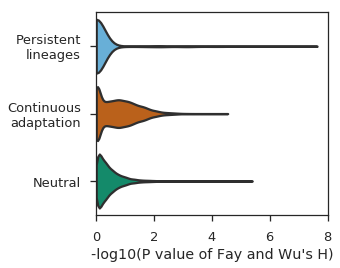

In [61]:
data_obs = df_metrics_persistent["H_pvalue_kingman"]
data = [data_obs, pvalue_H_BSC_persistent_sizeMatched, pvalue_H_neutral_persistent_sizeMatched]
data = [-np.log10(x) for x in data]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(ax=ax, data=data, orient="h", scale="width",
               cut=0, width=0.8, inner=None,
               palette=[myColors[1], myColors[2], myColors[3]])
ax.set_xlim(0,8)
ax.set_xlabel("-log10(P value of Fay and Wu's H)")
ax.set_yticklabels(["Persistent\nlineages", "Continuous\nadaptation", "Neutral"])
plt.tight_layout()
# save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_ViolinsSimulations_persistent", output_dir, output_suffix, output_formats, savefig_args)

# Statistics
print scipy.stats.mannwhitneyu(data[0], data[1])
print scipy.stats.mannwhitneyu(data[0], data[2])
print scipy.stats.mannwhitneyu(data[1], data[2])

In [48]:
# Sample for R
label = "Rest"
lineage_sizes = df_metrics_rest["num_seq"]
print lineage_sizes.shape[0], "lineages"

pvalue_H_neutral_rest_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                               fit_params_H_kingman,
                                                                               fit_params_H_kingman,
                                                                               10000)

pvalue_H_neutralExpanding_rest_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                               fit_params_H_neutralExpanding,
                                                                               fit_params_H_kingman,
                                                                               10000)

pvalue_H_BSC_rest_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                           fit_params_H_BSC,
                                                                           fit_params_H_kingman,
                                                                           10000)

171 lineages


MannwhitneyuResult(statistic=277115.0, pvalue=2.4523270550036037e-52)
MannwhitneyuResult(statistic=287354.0, pvalue=1.426847773539603e-50)
MannwhitneyuResult(statistic=35673149.0, pvalue=4.371418399285068e-270)


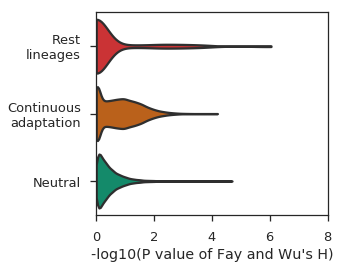

In [62]:
data_obs = df_metrics_rest["H_pvalue_kingman"]
data = [data_obs, pvalue_H_BSC_rest_sizeMatched, pvalue_H_neutral_rest_sizeMatched]
data = [-np.log10(x) for x in data]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(ax=ax, data=data, orient="h", scale="width",
               cut=0, width=0.8, inner=None,
               palette=[myColors[5], myColors[2], myColors[3]])
ax.set_xlim(0,8)
ax.set_xlabel("-log10(P value of Fay and Wu's H)")
ax.set_yticklabels(["Rest\nlineages", "Continuous\nadaptation", "Neutral"])
plt.tight_layout()
# save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_ViolinsSimulations_persistent", output_dir, output_suffix, output_formats, savefig_args)

# Statistics
print scipy.stats.mannwhitneyu(data[0], data[1])
print scipy.stats.mannwhitneyu(data[0], data[2])
print scipy.stats.mannwhitneyu(data[1], data[2])

# Plot distribution of P values by comparison with simulations (null model is neutral drift with population expansion)

In [82]:
# Sample for VR
label = "Vaccine-responsive"
lineage_sizes = df_metrics_expanded["num_seq"]
print lineage_sizes.shape[0], "lineages"

pvalue_H_neutralExpanding_expanded_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                               fit_params_H_neutralExpanding,
                                                                               fit_params_H_neutralExpanding,
                                                                               10000)

pvalue_H_BSC_expanded_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                           fit_params_H_BSC,
                                                                           fit_params_H_neutralExpanding,
                                                                           10000)

87 lineages


In [83]:
# Sample for P
label = "Persistent"
lineage_sizes = df_metrics_persistent["num_seq"]
print lineage_sizes.shape[0], "lineages"

pvalue_H_neutralExpanding_persistent_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                               fit_params_H_neutralExpanding,
                                                                               fit_params_H_neutralExpanding,
                                                                               10000)

pvalue_H_BSC_persistent_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                           fit_params_H_BSC,
                                                                           fit_params_H_neutralExpanding,
                                                                           10000)

192 lineages


MannwhitneyuResult(statistic=276644.0, pvalue=2.3783430573707877e-09)
MannwhitneyuResult(statistic=406431.0, pvalue=0.1453996926686042)
MannwhitneyuResult(statistic=146509.0, pvalue=0.0)


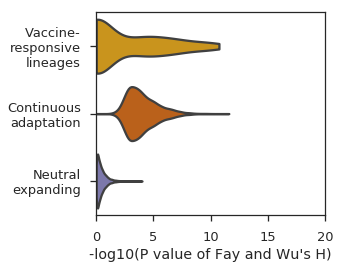

In [99]:
# Plot
data_obs = df_metrics_expanded["H_pvalue_neutralExpanding"]
data = [data_obs,
        pvalue_H_BSC_expanded_sizeMatched,
        pvalue_H_neutralExpanding_expanded_sizeMatched]

data = [-np.log10(x) for x in data]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(ax=ax, data=data, orient="h", scale="width",
               cut=0, width=0.8, inner=None,
               palette=[myColors[0], myColors[2], myColors[4]])
ax.set_xlim(0,20)
ax.set_xlabel("-log10(P value of Fay and Wu's H)")
ax.set_yticklabels(["Vaccine-\nresponsive\nlineages", "Continuous\nadaptation", "Neutral\nexpanding"])
plt.tight_layout()
# save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_ViolinsSimulationsExpansion_expanded", output_dir, output_suffix, output_formats, savefig_args)

# Statistics
print scipy.stats.mannwhitneyu(data[0], data[1])
print scipy.stats.mannwhitneyu(data[0], data[2])
print scipy.stats.mannwhitneyu(data[1], data[2])

MannwhitneyuResult(statistic=123511.0, pvalue=1.3145236709406272e-95)
MannwhitneyuResult(statistic=263880.0, pvalue=6.95285741467253e-67)
MannwhitneyuResult(statistic=190043.0, pvalue=0.0)


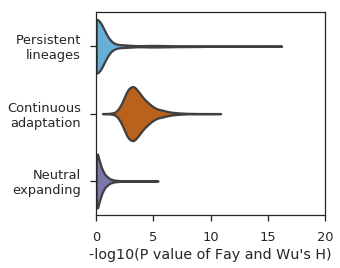

In [98]:
# Plot
data_obs = df_metrics_persistent["H_pvalue_neutralExpanding"]
data = [data_obs,
        pvalue_H_BSC_persistent_sizeMatched,
        pvalue_H_neutralExpanding_persistent_sizeMatched]

data = [-np.log10(x) for x in data]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(ax=ax, data=data, orient="h", scale="width",
               cut=0, width=0.8, inner=None,
               palette=[myColors[1], myColors[2], myColors[4]])
ax.set_xlim(0,20)
ax.set_xlabel("-log10(P value of Fay and Wu's H)")
ax.set_yticklabels(["Persistent\nlineages", "Continuous\nadaptation", "Neutral\nexpanding"])
plt.tight_layout()
# save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_ViolinsSimulationsExpansion_persistent", output_dir, output_suffix, output_formats, savefig_args)

# Statistics
print scipy.stats.mannwhitneyu(data[0], data[1])
print scipy.stats.mannwhitneyu(data[0], data[2])
print scipy.stats.mannwhitneyu(data[1], data[2])

# Examine selection versus expansion

In [30]:
df_dynamics = pd.concat([df_expanded, df_persistent, df_rest])

In [202]:
# Write to file
df_dynamics.to_csv("data/df_dynamics.csv")

SpearmanrResult(correlation=-0.26722749806269647, pvalue=8.51027342183608e-09)


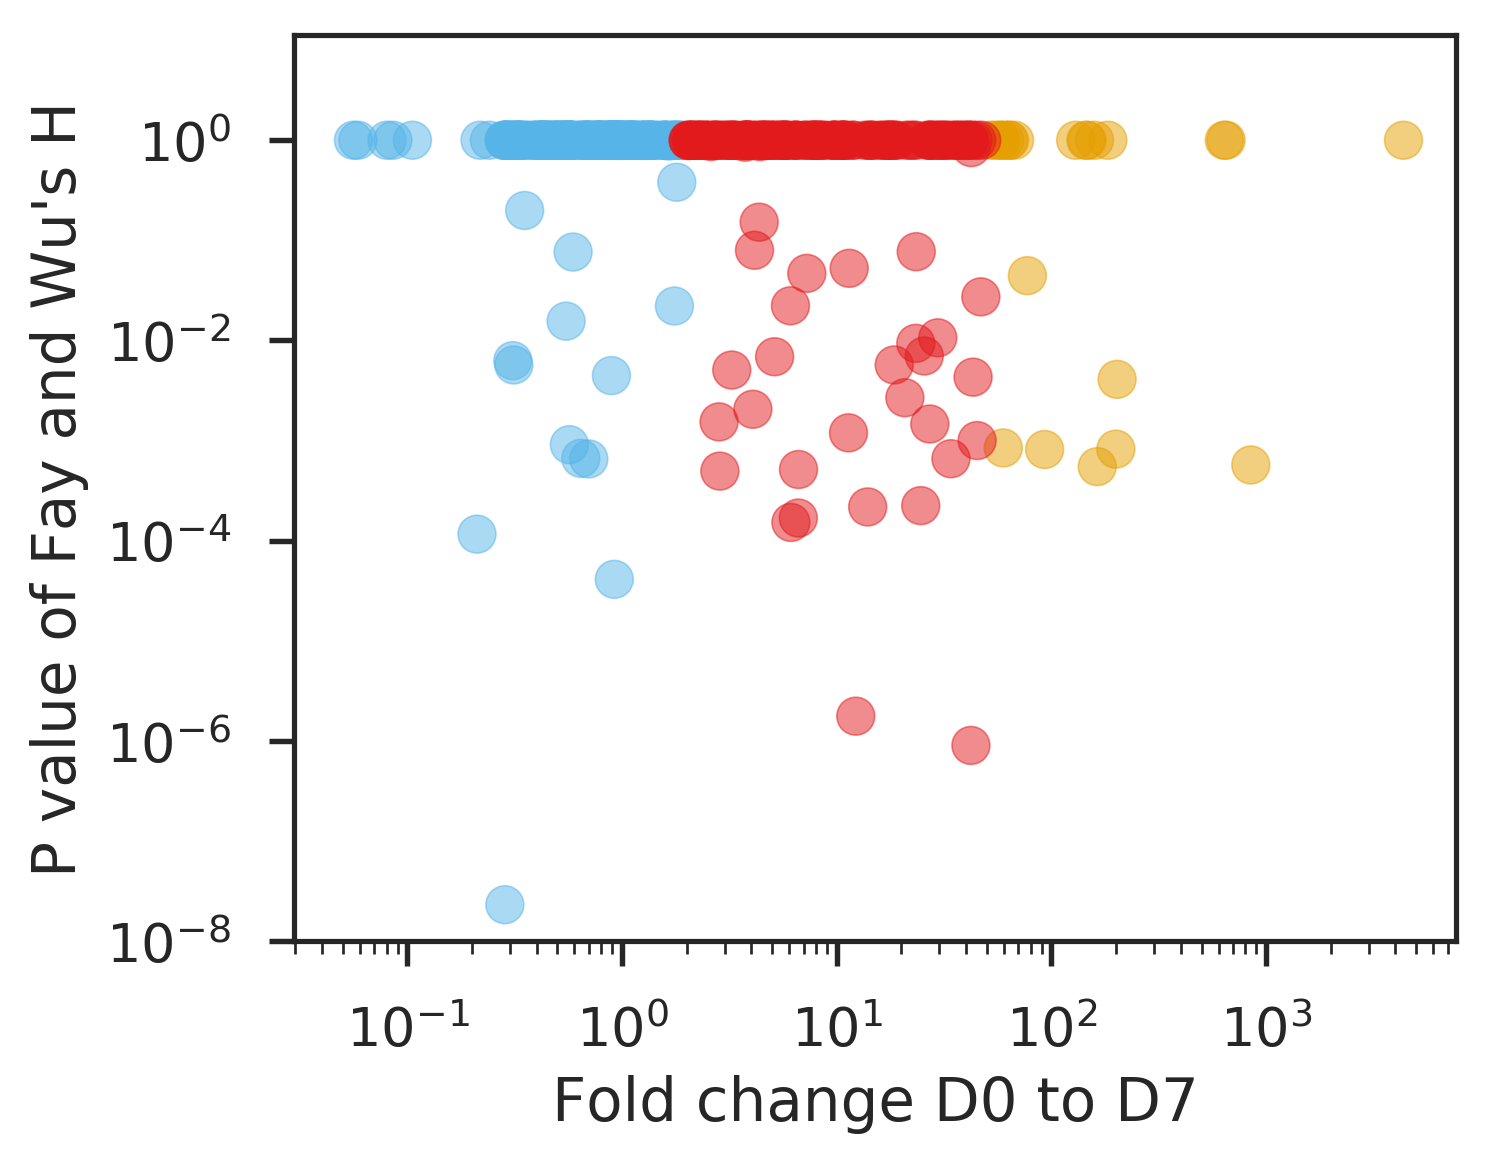

In [31]:
# Plot expansion versus selection

x = df_dynamics["V6_V3_ratio"]
y = df_metrics.loc[x.index]["H_pvalue_kingman"]
labels = df_metrics.loc[x.index]["label_dynamics"]
label_to_color = {"Vaccine-responsive": myColors[0], "Persistent": myColors[1], "Rest": myColors[5]}
c = [label_to_color[temp] for temp in labels]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(x, y, c=c, alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(bottom=1e-8)
ax.set_xlabel("Fold change D0 to D7")
ax.set_ylabel("P value of Fay and Wu's H")

print scipy.stats.spearmanr(x, y)

In [44]:
# Set flag for selected
df_metrics["is_selected"] = False
df_metrics["is_selected"].loc[df_metrics["H_pvalue_kingman"] < 0.05] = True
df_metrics["is_selected"].value_counts()

False    387
True      63
Name: is_selected, dtype: int64

SpearmanrResult(correlation=-0.26722749806269647, pvalue=8.51027342183608e-09)


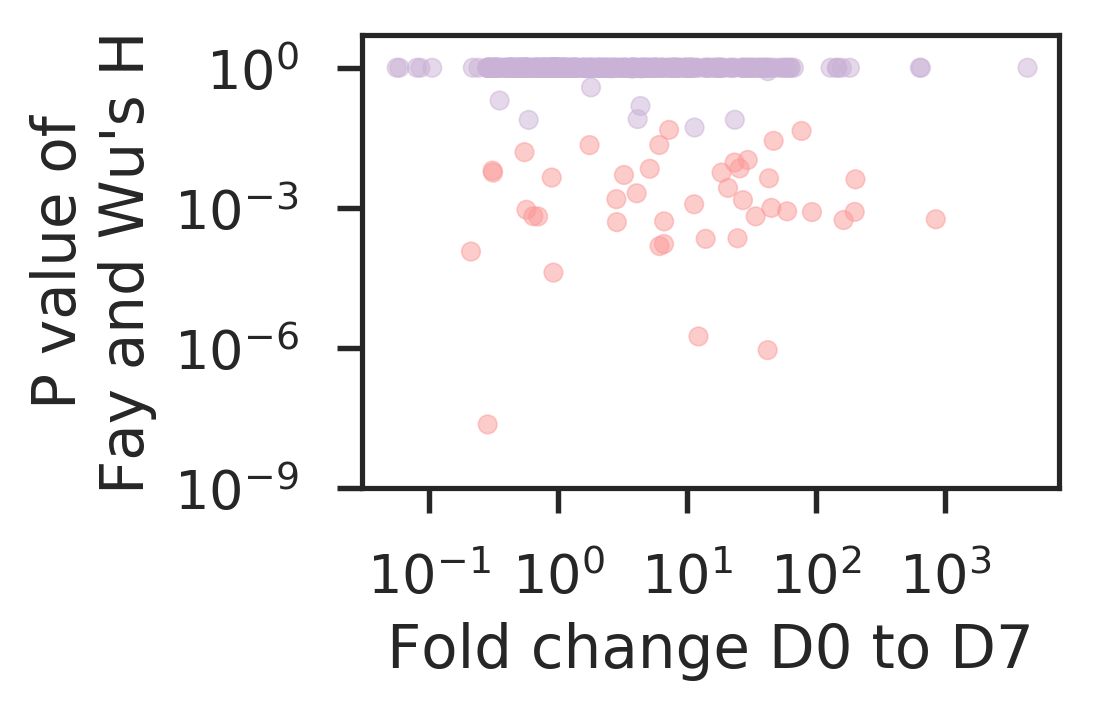

In [107]:
# Plot expansion versus selection, colored by selection

x = df_dynamics["V6_V3_ratio"]
y = df_metrics.loc[x.index]["H_pvalue_kingman"]
labels = df_metrics.loc[x.index]["is_selected"]
label_to_color = {True: myColors[6], False: myColors[7]}
c = [label_to_color[temp] for temp in labels]

fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.scatter(x, y, c=c, alpha=0.5, s=20)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-8, 5)
ax.set_yticks([1, 1e-3, 1e-6, 1e-9])
ax.set_xticks([1e-1, 1, 1e1, 1e2, 1e3])
ax.set_xlabel("Fold change D0 to D7")
ax.set_ylabel("P value of\nFay and Wu's H")
# ax.legend(bbox_to_anchor=(2, 0.5))

print scipy.stats.spearmanr(x, y)

save_figure(fig, "SelecExpanH_expansion_H",  output_dir, output_suffix, output_formats, savefig_args)

In [53]:
# Number of lineages included in analysis
x = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] < 0.05].index]["V6_V3_ratio"]
x2 = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] >= 0.05].index]["V6_V3_ratio"]

print "Selected", x.shape[0]
print "Non-selected", x2.shape[0]
print "Total", x.shape[0] + x2.shape[0]


Selected 63
Non-selected 387
Total 450


Median expansion
Selected 1.0546587524116406
Non-selected 0.2297222710358583
MannwhitneyuResult(statistic=4726.0, pvalue=6.164881488472954e-05)


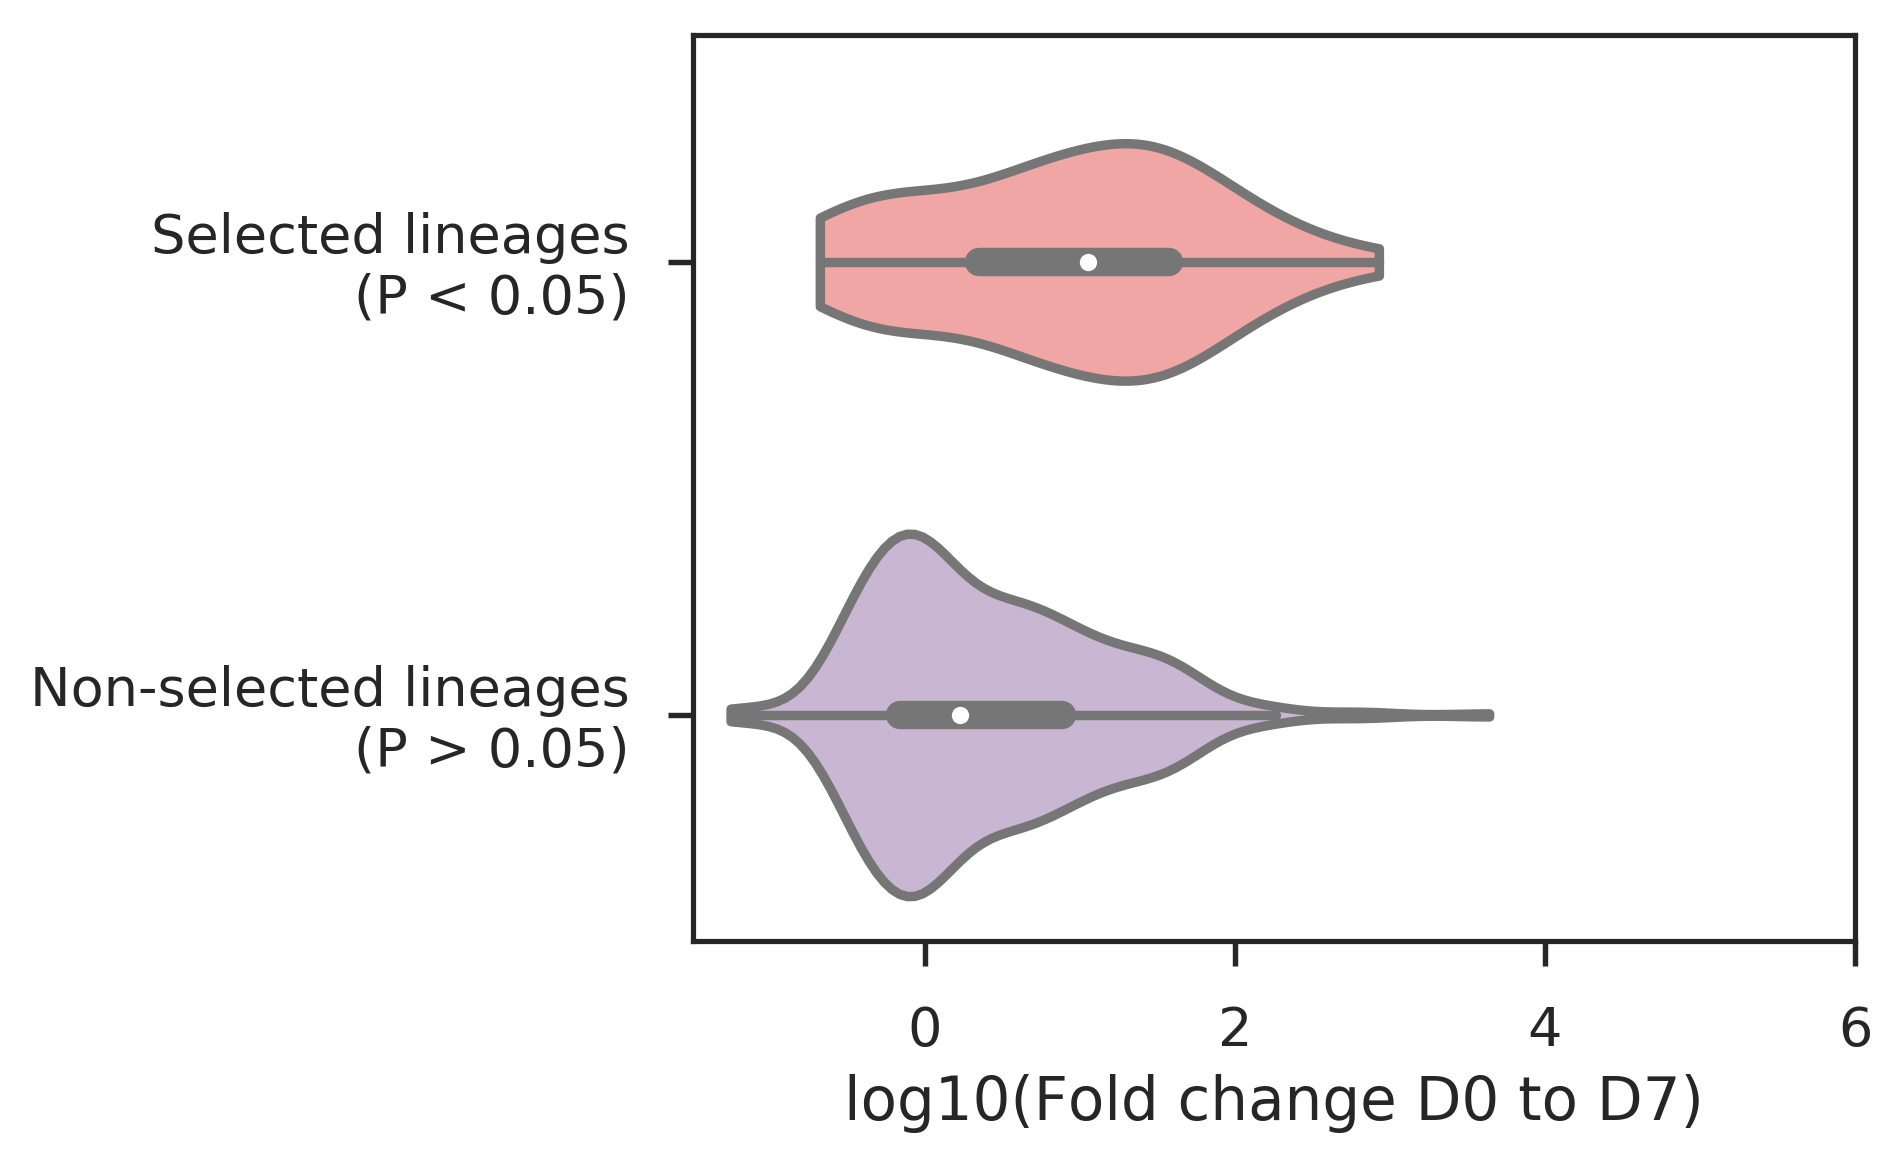

In [54]:
bins = np.logspace(-2, 4, 20)

x = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] < 0.05].index]["V6_V3_ratio"]
x = x[~np.isinf(x)] # remove infs
# x = x.replace(np.inf, 1e6) # replace infs with dummy value 1e6
x = np.log10(x)


x2 = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] >= 0.05].index]["V6_V3_ratio"]
x2 = x2[~np.isinf(x2)] # remove infs
# x2 = x2.replace(np.inf, 1e6) # replace infs with dummy value 1e6
x2 = np.log10(x2)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(ax=ax, data=[x, x2], orient="h", cut=0, palette=[myColors[6], myColors[7]])
ax.set_xlim(right=6)
ax.set_yticklabels(["Selected lineages\n(P < 0.05)", "Non-selected lineages\n(P > 0.05)"])
ax.set_xlabel("log10(Fold change D0 to D7)")

print "Median expansion"
print "Selected", np.median(x)
print "Non-selected", np.median(x2)
print scipy.stats.mannwhitneyu(x, x2)

# As expected, selected lineages tend to be more strongly amplified.
# However, some non-selected lineages are amplified (suggesting that neutral lineages are amplified).
# Also, some selected lineages are not amplified. This is expected: not all affinity-matured lineages have specificity for flu (or are activated by flu)

Median expansion
Selected 1.5318143165512494
Non-selected 0.38565197145293656
MannwhitneyuResult(statistic=7058.0, pvalue=3.960001299641507e-08)


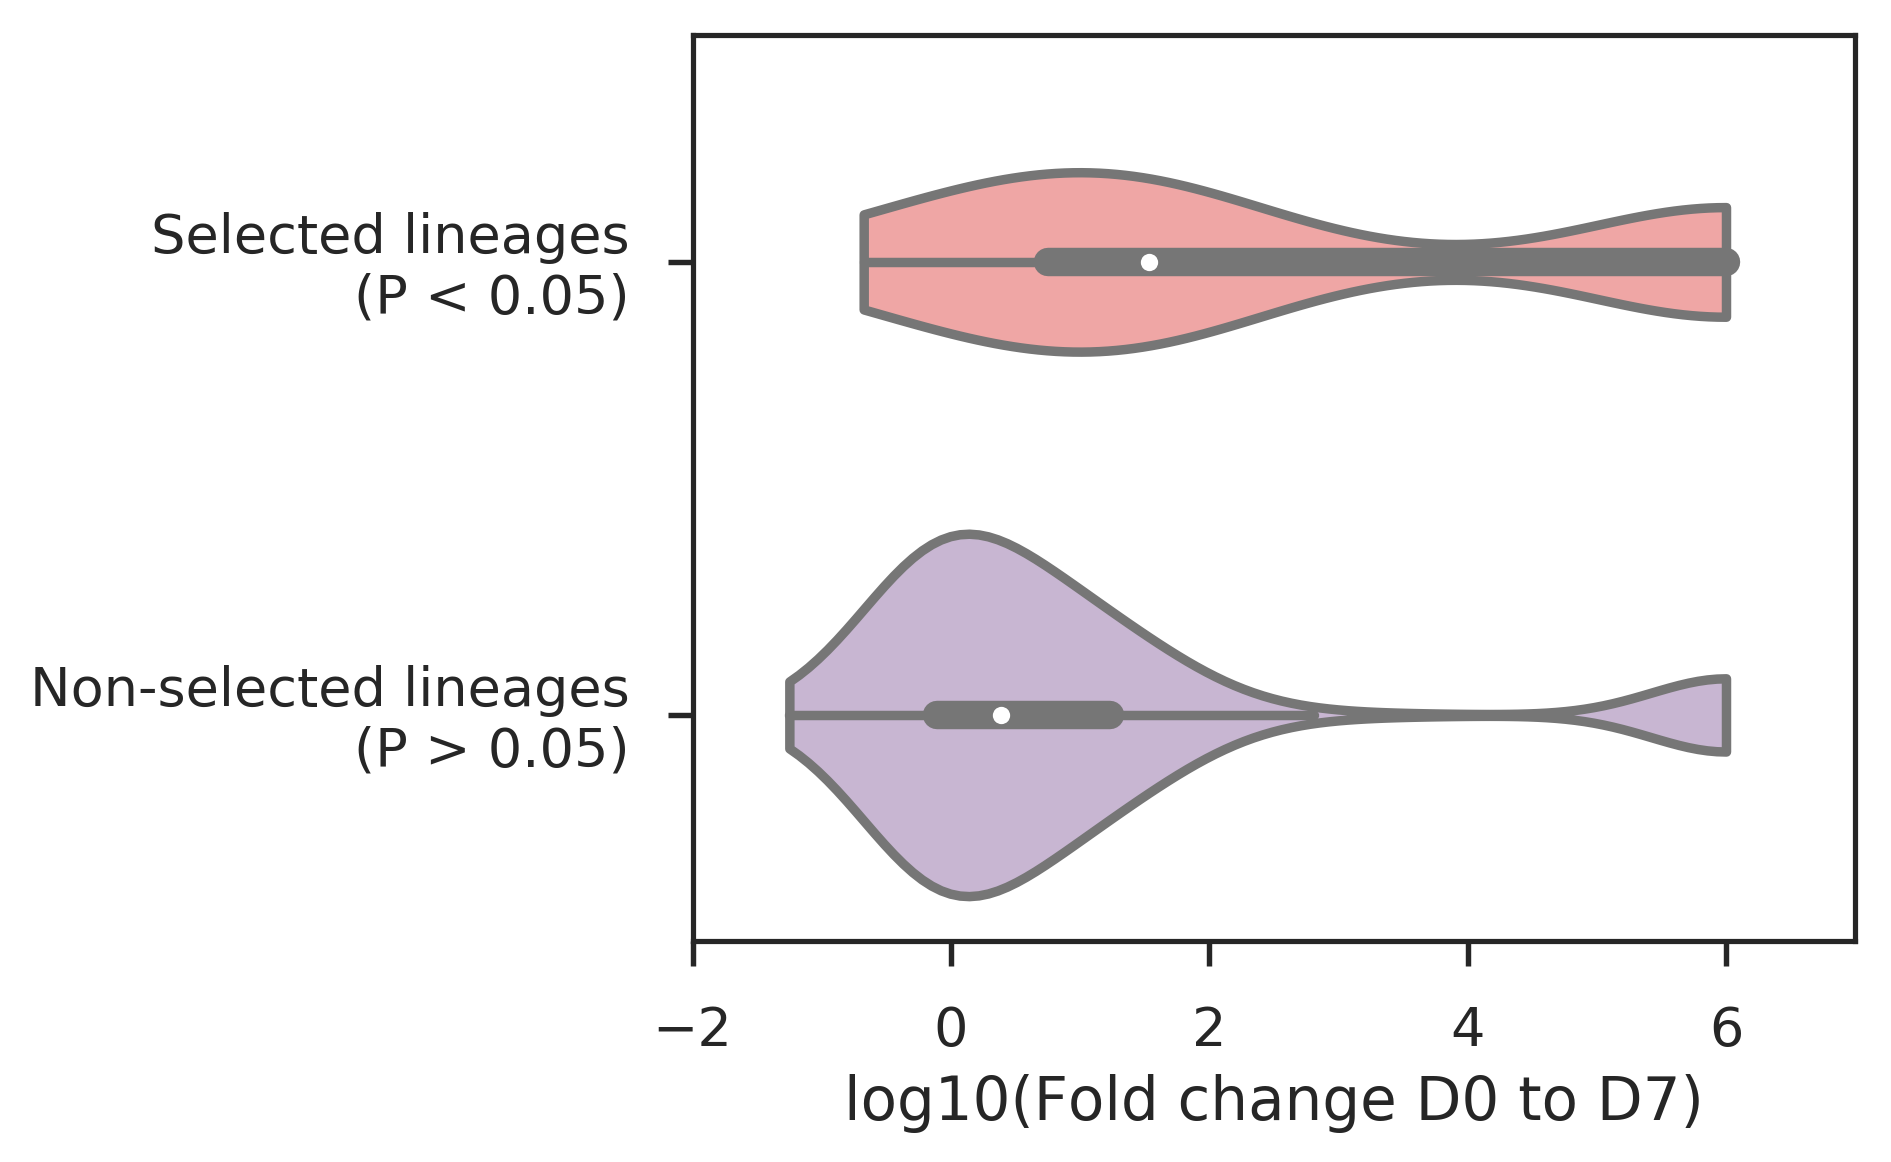

In [55]:
# janky way of representing Inf -- use dummy values on violin plot (misleading because there is in fact no density between 4 and 6)

bins = np.logspace(-2, 4, 20)

x = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] < 0.05].index]["V6_V3_ratio"]
# x = x[~np.isinf(x)] # remove infs
x = x.replace(np.inf, 1e6) # replace infs with dummy value 1e6
x = np.log10(x)


x2 = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] >= 0.05].index]["V6_V3_ratio"]
# x2 = x2[~np.isinf(x2)] # remove infs
x2 = x2.replace(np.inf, 1e6) # replace infs with dummy value 1e6
x2 = np.log10(x2)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(ax=ax, data=[x, x2], orient="h", cut=0, palette=[myColors[6], myColors[7]])
ax.set_xlim(left=-2, right=7)
ax.set_yticklabels(["Selected lineages\n(P < 0.05)", "Non-selected lineages\n(P > 0.05)"])
ax.set_xlabel("log10(Fold change D0 to D7)")

print "Median expansion"
print "Selected", np.median(x)
print "Non-selected", np.median(x2)
print scipy.stats.mannwhitneyu(x, x2)

Median expansion
Selected 1.0546587524116406
Non-selected 0.2297222710358583
MannwhitneyuResult(statistic=4726.0, pvalue=6.164881488472954e-05)
Number of lineages
43
343


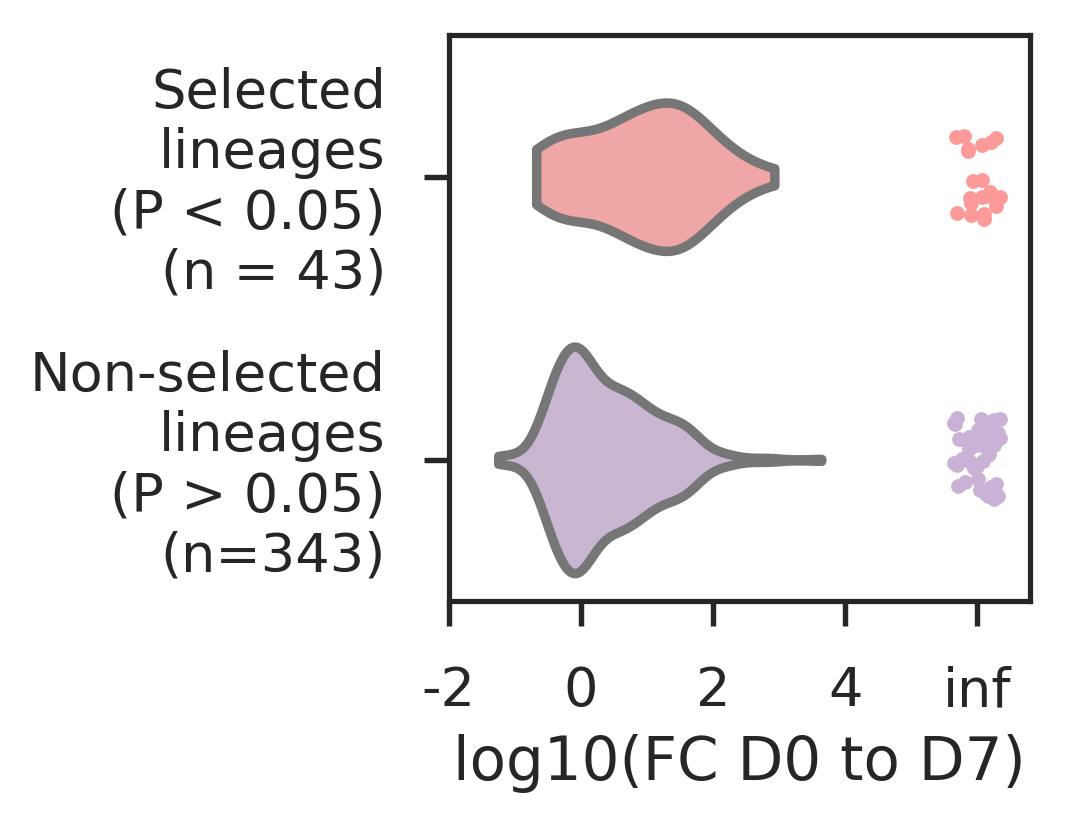

In [101]:
# add points at inf

bins = np.logspace(-2, 4, 20)

x = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] < 0.05].index]["V6_V3_ratio"]
x = x[~np.isinf(x)] # remove infs
# x = x.replace(np.inf, 1e6) # replace infs with dummy value 1e6
x = np.log10(x)

x2 = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] >= 0.05].index]["V6_V3_ratio"]
x2 = x2[~np.isinf(x2)] # remove infs
# x2 = x2.replace(np.inf, 1e6) # replace infs with dummy value 1e6
x2 = np.log10(x2)

fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
sns.violinplot(ax=ax, data=[x, x2], orient="h", inner=None, cut=0, palette=[myColors[6], myColors[7]])
ax.set_xlim(left=-2, right=6.8)
ax.set_yticklabels(["Selected\nlineages\n(P < 0.05)\n(n = 43)", "Non-selected\nlineages\n(P > 0.05)\n(n=343)"])
ax.set_xlabel("log10(FC D0 to D7)")

print "Median expansion"
print "Selected", np.median(x)
print "Non-selected", np.median(x2)
print scipy.stats.mannwhitneyu(x, x2)

print "Number of lineages"
print len(x)
print len(x2)

# Draw points at inf
x = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] < 0.05].index]["V6_V3_ratio"]
n_inf = sum(np.isinf(x))
x_jiggles = np.random.uniform(-0.35, 0.35, n_inf) + 6
y_jiggles = np.random.uniform(-0.15, 0.15, n_inf)
ax.scatter(x_jiggles, y_jiggles, alpha=1, s=10, c=myColors[6])

x = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] > 0.05].index]["V6_V3_ratio"]
n_inf = sum(np.isinf(x))
x_jiggles = np.random.uniform(-0.35, 0.35, n_inf) + 6
y_jiggles = np.random.uniform(-0.15, 0.15, n_inf) + 1
ax.scatter(x_jiggles, y_jiggles, alpha=1, s=10, c=myColors[7])

ax.set_xticks([-2, 0, 2, 4, 6])
ax.set_xticklabels([-2, 0, 2, 4, "inf"])

# plt.tight_layout()

# As expected, selected lineages tend to be more strongly amplified.
# However, some non-selected lineages are amplified (suggesting that neutral lineages are amplified).
# Also, some selected lineages are not amplified. This is expected: not all affinity-matured lineages have specificity for flu (or are activated by flu)

save_figure(fig, "SelecExpanH_expansion_H_violin",  output_dir, output_suffix, output_formats, savefig_args)

In [89]:
# If we use selection as a metric, how good are we at finding vaccine-responsive lineages?

# In other words, among selected lineages, what fraction are vaccine-responsive?

# Among non-selected lineages, what fraction are vaccine-responsive?

V6_V3_ratio_cutoffs = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

z = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] < 0.05].index]["V6_V3_ratio"]
frac_expanded_selected = np.array([np.mean(z > cutoff) for cutoff in V6_V3_ratio_cutoffs])

z = df_dynamics.loc[df_metrics.loc[df_metrics["H_pvalue_kingman"] > 0.05].index]["V6_V3_ratio"]
frac_expanded_notSelected = np.array([np.mean(z > cutoff) for cutoff in V6_V3_ratio_cutoffs])

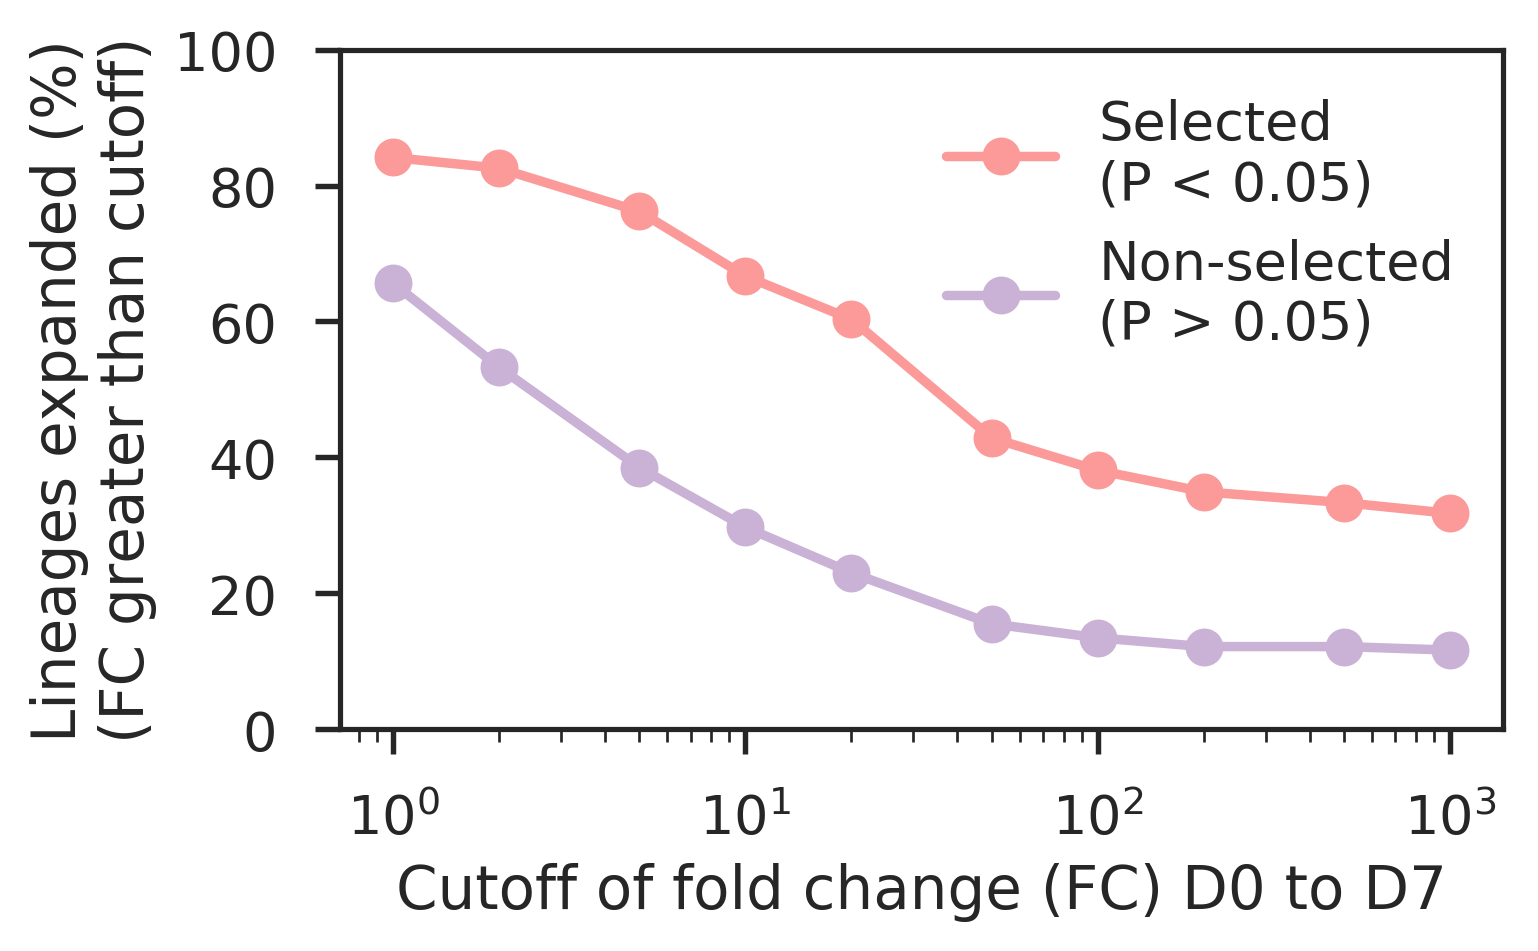

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))

ax.plot(V6_V3_ratio_cutoffs, frac_expanded_selected*100, c=myColors[6], label="Selected\n(P < 0.05)", marker="o")
ax.plot(V6_V3_ratio_cutoffs, frac_expanded_notSelected*100, c=myColors[7], label="Non-selected\n(P > 0.05)", marker="o")

ax.set_xscale("log")
ax.set_ylim(0, 100)
ax.set_xlabel("Cutoff of fold change (FC) D0 to D7")
ax.set_ylabel("Lineages expanded (%)\n(FC greater than cutoff)")
# ax.legend(bbox_to_anchor=(1.05, 0.65))
ax.legend(loc="upper right", frameon=False)

save_figure(fig, "SelecExpanH_expansion_vs_cutoff",  output_dir, output_suffix, output_formats, savefig_args)

# Write results to file

In [198]:
df_dynamics.head()

,sequences_V1,molecules_V1,sequences_V2,molecules_V2,sequences_V3,molecules_V3,sequences_V4,molecules_V4,sequences_V5,molecules_V5,...,sequences_V2_normed,sequences_V3_normed,sequences_V4_normed,sequences_V5_normed,sequences_V6_normed,sequences_V7_normed,sequences_V8_normed,V3_V1_ratio,onset,V6_V3_ratio
uid,,,,,,,,,,,,,,,,,,,,,
70201010000000001,9.0,30.0,1.0,6.0,2.0,5.0,2.0,5.0,2.0,10.0,...,0.000139,0.000382,0.000790,0.000151,0.324309,0.000000,0.000313,0.681657,0,848.554106
20201010000000001,0.0,0.0,2.0,4.0,1.0,1.0,6.0,59.0,0.0,0.0,...,0.000034,0.000019,0.000159,0.000000,0.084574,0.026856,0.005361,inf,1,4364.622308
20201010000000267,1.0,3.0,4.0,10.0,0.0,0.0,2.0,5.0,9.0,29.0,...,0.000068,0.000000,0.000053,0.000189,0.066906,0.021466,0.006024,0.000000,0,inf
60201010000000781,0.0,0.0,0.0,0.0,7.0,20.0,3.0,4.0,0.0,0.0,...,0.000000,0.000274,0.000100,0.000000,0.050069,0.021324,0.002521,inf,2,183.023279
20201010000000362,4.0,8.0,7.0,17.0,9.0,17.0,0.0,0.0,9.0,24.0,...,0.000120,0.000174,0.000000,0.000189,0.027668,0.023075,0.008364,1.982827,0,158.651843


In [199]:
df_metrics.shape

(450, 5)

# Sensitivity of selection for calling vaccine-responsive lineages

In [70]:
A = df_metrics.loc[df_metrics["H_pvalue_neutralExpanding"] < 0.05]["label_dynamics"].value_counts()
A

Vaccine-responsive    37
Persistent            23
Name: label_dynamics, dtype: int64

In [71]:
B = df_metrics["label_dynamics"].value_counts()
B

Persistent            192
Vaccine-responsive     87
Name: label_dynamics, dtype: int64

In [73]:
# Enrichment for Vaccine-responsive
(A["Vaccine-responsive"] / np.sum(A)) / (B["Vaccine-responsive"] / np.sum(B))

1.9775862068965517